In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [13]:
import os
import json
import re
import torch
import pickle as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from ipywidgets import interact
from io import StringIO
from tqdm.auto import tqdm
from omegaconf import OmegaConf

In [14]:
from plotting import (
    plot_confusion_matrix,
    plot_bar,
    plot_metric_df,
    plot_aupr_curves,
    plot_distributions,
)
from logutil import BaseLogger, parse_log
logg = BaseLogger("nb_debug")

# Parse and Compare Logs

In [30]:

log_files = [
## List of Run Names Here
]
    
key_log_dict = {}
key_result_dict = {}
for k in log_files:
    try:
        key_log_dict[k] = f"../logs/{k}/log.txt" 
        key_result_dict[k] = parse_log(key_log_dict[k])
    except Exception:
        print(f"Failed to load {k}")

max_epoch = max(v[1].Epoch.max() for v in key_result_dict.values())
metric_names = key_result_dict[list(key_result_dict.keys())[0]][1]["Metric"].unique()

In [31]:
run_selector = widgets.SelectMultiple(
    options=sorted(list(key_log_dict.keys())),
    value=[list(key_log_dict.keys())[0]],
    description='Runs',
    disabled=False
)

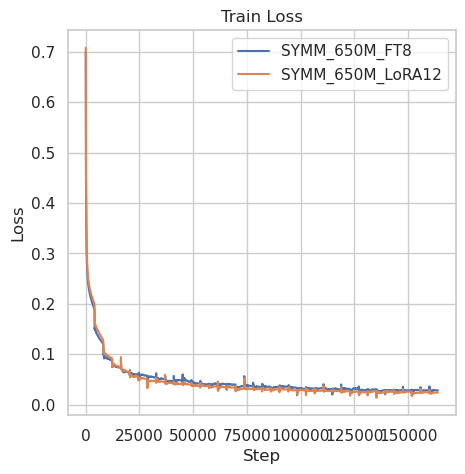

In [32]:
sns.set(style = "whitegrid")

def train_loss(Runs = sorted(list(key_log_dict.keys()))):
    for k, v in key_result_dict.items():
        if k not in Runs:
            continue
        train_history, metric_df, cfg = v
        plt.plot(train_history["Step"], train_history["Loss"], label = k)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.legend()
    plt.show()
    
train_loss()

In [33]:
for k in key_result_dict.keys():
    v = key_result_dict[k]
    _, metric_df, cfg = v
    subset_df = metric_df[metric_df["Subset"] == "valid"]
    metdf = subset_df[subset_df["Metric"] == "aupr"]
    metdf = metdf[metdf["Epoch"] <= 40]
    
    argmax = metdf["Value"].argmax()
    print(f'{k}, epoch {metdf.iloc[argmax]["Epoch"]}, val aupr {metdf.iloc[argmax]["Value"]}')

SYMM_650M_FT8, epoch 23, val aupr 0.594213
SYMM_650M_LoRA12, epoch 32, val aupr 0.532845


What do you want to name this figure? symm_ft_lora_train_loss


Saving to results/symm_ft_lora_train_loss.png


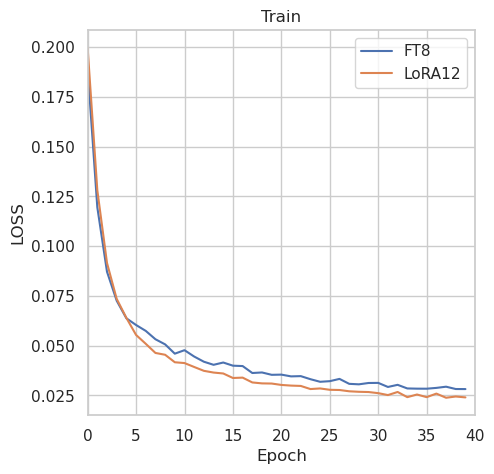

In [36]:
def show_metric(Metric = "loss", Subset = "train", Runs = sorted(list(key_log_dict.keys()))):
    
    sns.set(style = "whitegrid", rc={'figure.figsize':(5,5)})
    for k, v in key_result_dict.items():
        if k not in Runs:
            continue
        _, metric_df, cfg = v
        subset_df = metric_df[metric_df["Subset"] == Subset]
        metdf = subset_df[subset_df["Metric"] == Metric]
        plt.plot(metdf["Epoch"], metdf["Value"], label = k.split("_")[-1])
    plt.title(Subset.title())
    plt.xlabel("Epoch")
    plt.xlim(0,40)
    plt.ylabel(Metric.upper())
    plt.legend()
    figname = input("What do you want to name this figure?")
    plt.savefig(f"../figures/{figname.strip()}.png",bbox_inches="tight",dpi=300)
    plt.savefig(f"../figures/{figname.strip()}.svg",bbox_inches="tight",dpi=300)
    print(f"Saving to results/{figname.strip()}.png")
    plt.show()
    
show_metric()
